<a href="https://colab.research.google.com/github/xEsseax/kaggle/blob/main/titanic_spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение

Проект сделан в рамках проекта Kaggle Titanic SpaceShip. Необходимо предсказать, был ли пассажир перенесен в другое измерение во время столкновения космического корабля «Титаник» с пространственно-временной аномалией. В распоряжении имеется набор личных записей, извлеченных из поврежденной компьютерной системы корабля.

# Описание данных

train.csv - тренировочный датасет с признаками пассажиров, содержит следующие колонки:

- PassengerID - уникальный номер пассажира, формирующийся как gggg_pp, где gggg-номер группы, которой принадлежит пассажир, pp - номер внутри группы. Люди внутри группы - часто слены семьи, но это не является правилом
- HomePlanet - планета отправления, чаще всего она же - планета проживания
- CryoSleep - показывает, был ли пассажир в состоянии анабиоза на время полёта. Если эта опция подключена - пассажир находится в своей каюте на время полёта
-Cabin - номер кабины. Имеет вид палуба/число/сторона, где P соответсвует левому борту, а S - правому
- Destination - планета назначения (конечный пункт)
- Age - возраст пассажира
- VIP - оплатил ли пассажир дополнительный VIP-сервис на время полёта
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - сумма, потраченная пассажиром на дополнительные развлечения на борту
- Name - фамилия и имя пассажира
- Transported - был ли пассажир пересён в другое измерение. Целевой признак


test.csv - тестовый набор данных.

sample_submission.csv -  пример корректного формата предсказаний, содержит два столбца: уникальный номер пассажира PassengerID и целевой признак Transported.

# Технический раздел

In [1]:
pip install --upgrade matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import (
    make_column_transformer,
    make_column_selector
)

In [3]:
# функция для обзора датасета
def ds_review(ds):
    print(f'Размер датасета = {ds.shape}')
    print(f'Информация о типе данных и количестве пропусков:')
    print(ds.info())
    display(ds.head())


In [4]:
#графическое отображение распределения значений в столбце
def column_draw(column, ds):
    if type(ds[column][0])==bool:
      col = ds[column].astype('str')
    else:
      col = ds[column]

    col.hist()
    plt.xlabel('meaning')
    plt.ylabel('quantity')
    plt.title(ds[column].name)

In [5]:
def column_draw_xlim(column, ds, x_lim):
    if type(ds[column][0])==bool or type(ds[column][0])==np.bool_:
      col = ds[column].astype('str')
    else:
      col = ds[column]

    col.hist(bins=100)
    plt.xlabel('meaning')
    plt.ylabel('quantity')
    plt.xlim(0, x_lim)
    plt.title(ds[column].name)

In [6]:
# функция для создания признака группы пассажира
def passenger_group(row):
  return row['PassengerId'].split('_')[0]

# Чтение и обзор данных

In [7]:
try:
  train = pd.read_csv('./data/train.csv')
  test = pd.read_csv('./data/test.csv')
except:
  train = pd.read_csv('train.csv')
  test = pd.read_csv('test.csv')

In [8]:
ds_review(train)

Размер датасета = (8693, 14)
Информация о типе данных и количестве пропусков:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Приблизительно 8700 строк, 12 признаков + целевой. Во всех столбцах кроме идентификатора пассажира и целевого признака присутсвуют пропуски. Типы данных совпадают с ожидаемым.

In [9]:
#сохраняем изначальное количество для сравнения после обработки
train_shape_before = train.shape

Смотрим на распределения признаков, там, где это возможно - заполняем пропуски.
Удалять строки в тестовой выборке нельзя, оставлять пропуски "как есть" тоже, так как обучить модели на таких данных будет невозможно. Значит, пропуски нужно заполнять в любом случае (в крайнем случае - заглушкой).

## HomePlanet и Destination

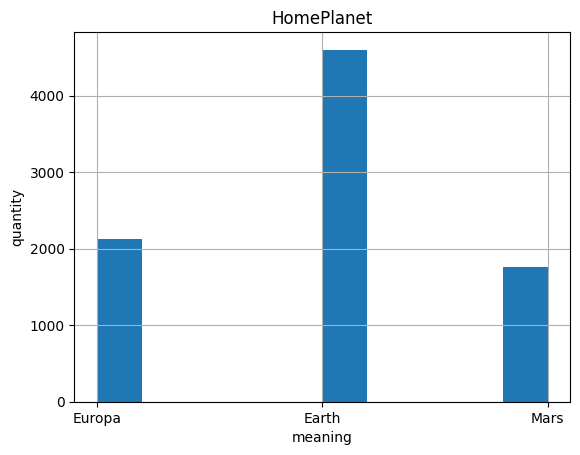

In [10]:
column_draw('HomePlanet', train)

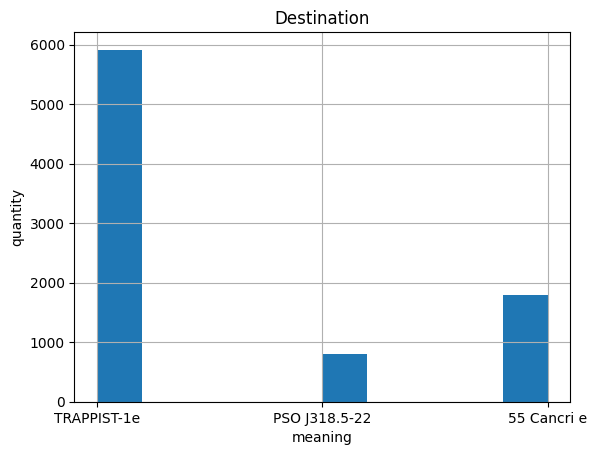

In [11]:
column_draw('Destination', train)

Проверяем, сколько пассажиров с пропусками и в точке начала, и в точке конца маршрута:

In [12]:
len(train[train['Destination'].isna() & train['HomePlanet'].isna()])

4

То есть преимущественно один из пунктов известен.

Итого, у нас три домашние планеты, основная масса - с Земли. Суммарно порядка четырёхсот пропусков составляют четыре процента датасета. Технически можно себе позволить их удалить, но попробуем восстановить по следующей логике:

Известно, что ID пассажира формируется следующим образом: каждый ID имеет вид gggg_pp, где pp - номер пассажира, а gggg - номер  группы, в которой путешествует пассажир. Значит, можно сделать так: выделим отдельный признак группы и предположим, что внутри одной путешествующей группы пункты отправления и назначения совпадают.

In [13]:
train['PassengerId'].head(10)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
5    0005_01
6    0006_01
7    0006_02
8    0007_01
9    0008_01
Name: PassengerId, dtype: object

Восстановить таким способом все пропуски, вероятно, не получится - видно, что здесь есть и одинокие странники. Но посмотрим, что получится))

In [14]:
train['PassengerGroup'] = train.apply(passenger_group, axis=1)

Посмотрим на разброс пунктов отправления и назначения внутри одной группы:

In [15]:
train[train['PassengerGroup']=='8728']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup
8162,8728_01,Earth,NaN,F/1798/P,TRAPPIST-1e,32.0,False,258.0,500.0,3.0,15.0,128.0,Justie Fulloydez,True,8728
8163,8728_02,Earth,False,G/1416/P,TRAPPIST-1e,55.0,False,694.0,0.0,1.0,87.0,0.0,Eilan Fulloydez,False,8728
8164,8728_03,Earth,False,F/1798/P,TRAPPIST-1e,23.0,False,1254.0,0.0,45.0,0.0,0.0,Fanna Fulloydez,False,8728
8165,8728_04,Earth,False,F/1798/P,PSO J318.5-22,38.0,False,647.0,23.0,1.0,0.0,0.0,Ginald Fulloydez,False,8728
8166,8728_05,Earth,True,G/1416/P,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Weslie Fulloydez,True,8728
8167,8728_06,Earth,True,G/1416/P,PSO J318.5-22,32.0,False,0.0,0.0,0.0,0.0,0.0,Kendy Fulloydez,False,8728
8168,8728_07,Earth,False,NaN,TRAPPIST-1e,44.0,False,266.0,3.0,2.0,0.0,748.0,Delley Fulloydez,False,8728
8169,8728_08,Earth,False,G/1416/P,TRAPPIST-1e,62.0,False,0.0,592.0,164.0,0.0,0.0,Franda Fulloydez,True,8728


In [16]:
train[train['PassengerGroup']=='4498']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup
4221,4498_01,Earth,False,G/734/S,55 Cancri e,11.0,False,0.0,0.0,0.0,0.0,0.0,Valex Munozanson,False,4498
4222,4498_02,Earth,True,G/734/S,PSO J318.5-22,14.0,False,0.0,0.0,0.0,0.0,0.0,Loise Beckeetter,False,4498
4223,4498_03,Earth,True,G/734/S,PSO J318.5-22,4.0,False,0.0,0.0,0.0,0.0,0.0,Lorie Beckeetter,True,4498
4224,4498_04,Earth,False,G/734/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,NaN,Dandy Munozanson,False,4498
4225,4498_05,Earth,True,G/734/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Karay Beckeetter,True,4498
4226,4498_06,Earth,False,G/734/S,TRAPPIST-1e,15.0,False,0.0,893.0,0.0,0.0,0.0,Line Munozanson,True,4498
4227,4498_07,Earth,False,G/734/S,TRAPPIST-1e,39.0,False,0.0,2.0,0.0,69.0,836.0,Dary Mallerez,False,4498
4228,4498_08,Earth,False,G/734/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,Kendy Munozanson,False,4498


Пункт отправления внутри одной группы кажется одинаковым. В пункте назначения внутри одной группы явно присутствует вариативность - однако, у большинства членов группы он совпадает. Заполним пропуски в этих столбцах самым частым значением внутри группы.

In [17]:
for col in ['HomePlanet', 'Destination']:
  for group in train['PassengerGroup'].unique():
    try:
      train.loc[(train['PassengerGroup']==group) & (train[col].isna()), col] = \
        train[train['PassengerGroup']==group][col].value_counts().index[0]
    except:
      pass

Остальные пропуски заполним самым популярным значением:

In [18]:
for col in ['HomePlanet', 'Destination']:
  train[col] = train[col].fillna(train[col].value_counts().index[0])

## Криосон

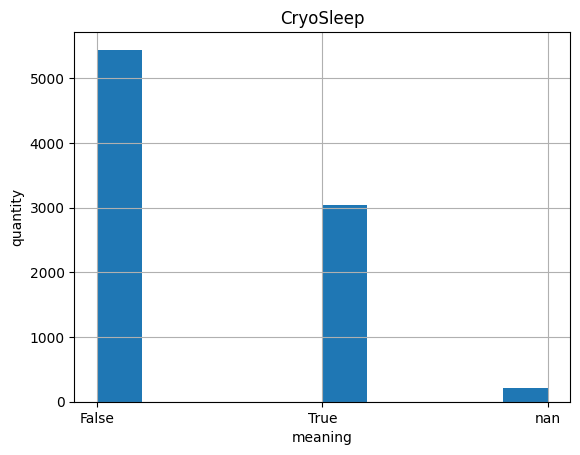

In [19]:
column_draw('CryoSleep', train)

Приблизительно 2/3 пассажиров предпочитают бодрствовать во время полёта. Есть небольшое количество пропусков, которые можно попробовать восполнить следующим образом: у нас есть некоторые столбцы с расходами на допуслуги во время полёта. Будем считать, что если пассажир тратит на фудкорт, спа, покупки и тд - значит, точно не спит. Также есть колонка с ВИП-сервисом - можно изучить по имеющимся данным, насколько часто пассажиры оплачивают криосон и вип-сервис одновременно.

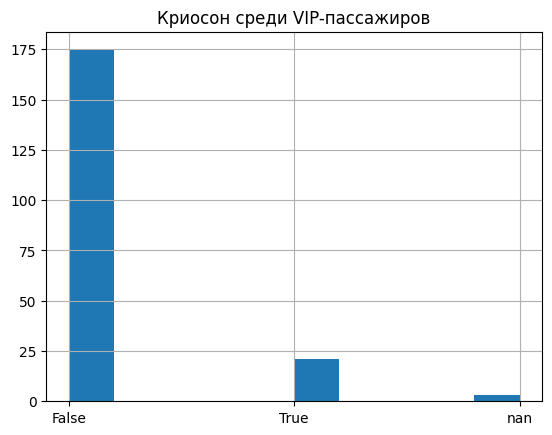

In [20]:
train[train['VIP']==True]['CryoSleep'].astype('str').hist()
plt.title('Криосон среди VIP-пассажиров');

Как и предполагалось, подавляющее большинство пассажиров, тратящихся на VIP-сервис, предпочитают не спать (и пользоваться благами доп. обслуживания).

Изучим использование услуги криосна в зависимости от пункта отправления и назначения: может быть так, что услуга криосна сильно зависит от дальности полёта.

Значит, пропуски в столбце криосна заполним следующим образом:
- если подключен VIP-сервис - пассажир не спит
- если есть траты на доп.услуги - пассажир не спит

In [21]:
services_columns = train.select_dtypes(include=['float64']).columns.drop('Age')

In [22]:
def cryo(row):
  if row['VIP']==True:
    return False
  elif sum([row[column] for column in services_columns]) > 0:
    return False

In [23]:
train.loc[train['CryoSleep'].isna(), 'CryoSleep'] = train[train['CryoSleep'].isna()].apply(cryo, axis=1)

Изучим использование услуги криосна в зависимости от пункта отправления и назначения: может быть так, что услуга криосна сильно зависит от дальности полёта.

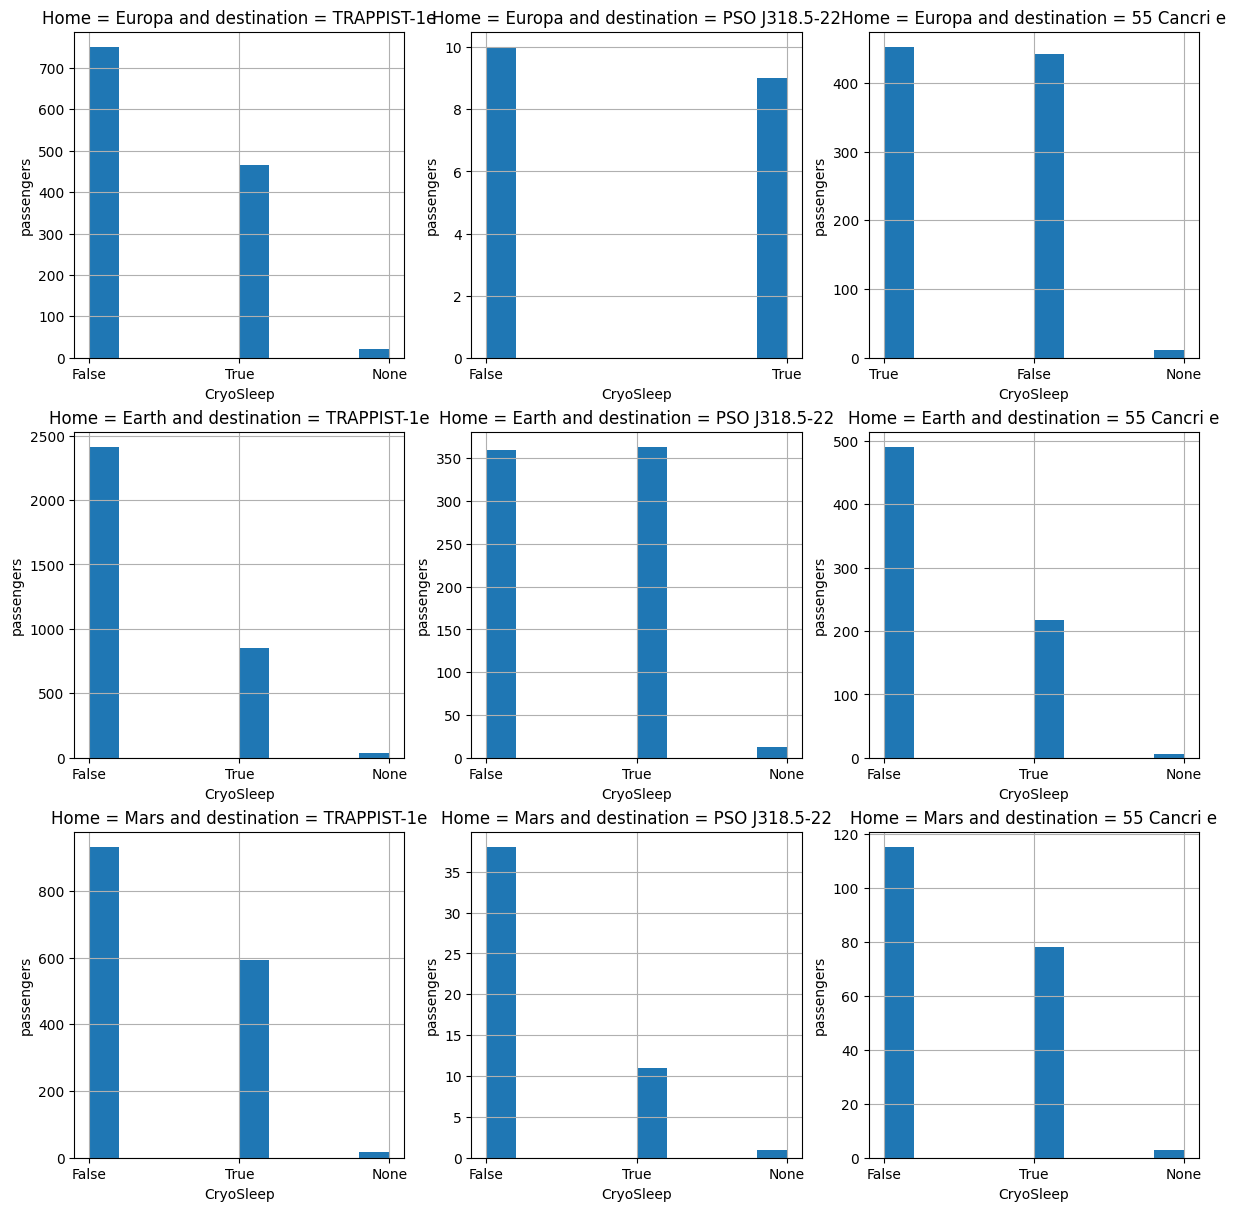

In [24]:
i=1
plt.figure(figsize=(12, 12), layout="constrained")
for home in train['HomePlanet'].unique():
      for dest in train['Destination'].unique():
        plt.subplot(3, 3, i)
        train[(train['HomePlanet']==home) & (train['Destination']==dest)]['CryoSleep'].astype('str').hist()
        plt.xlabel('CryoSleep')
        plt.ylabel('passengers')
        plt.title(f'Home = {home} and destination = {dest}')
        i+=1

К сожалению, дальность расположения пунктов относительно друг друга не знаем (можно было бы при заполнении пропусков сделать фильтр по пороговому значению дальности полёта) - но явно видим, что полёты с планеты Европа на 55 Cancri e - единственные, гди криосна больше его отсутствия (хоть и незначительно). Также в полётах с Европы на PSO J318.5-22 количество спящих лишь немного уступает бодрствующим - значит, можно предположить, что Европа находится дальше всех.

Дополним алгоритм заполнения пропусков: будем считать, что при полётах с Европы на 55 Cancri e криосон подключен, а все оставшиеся пропуски заполним False.

In [25]:
train.loc[(train['HomePlanet']=='Europa') & (train['Destination']=='55 Cancri e') & (train['CryoSleep'].isna()), 'CryoSleep'] = True

In [26]:
train['CryoSleep'] = train['CryoSleep'].fillna(False)

## Сумма, потраченная пассажиром на допсервисы

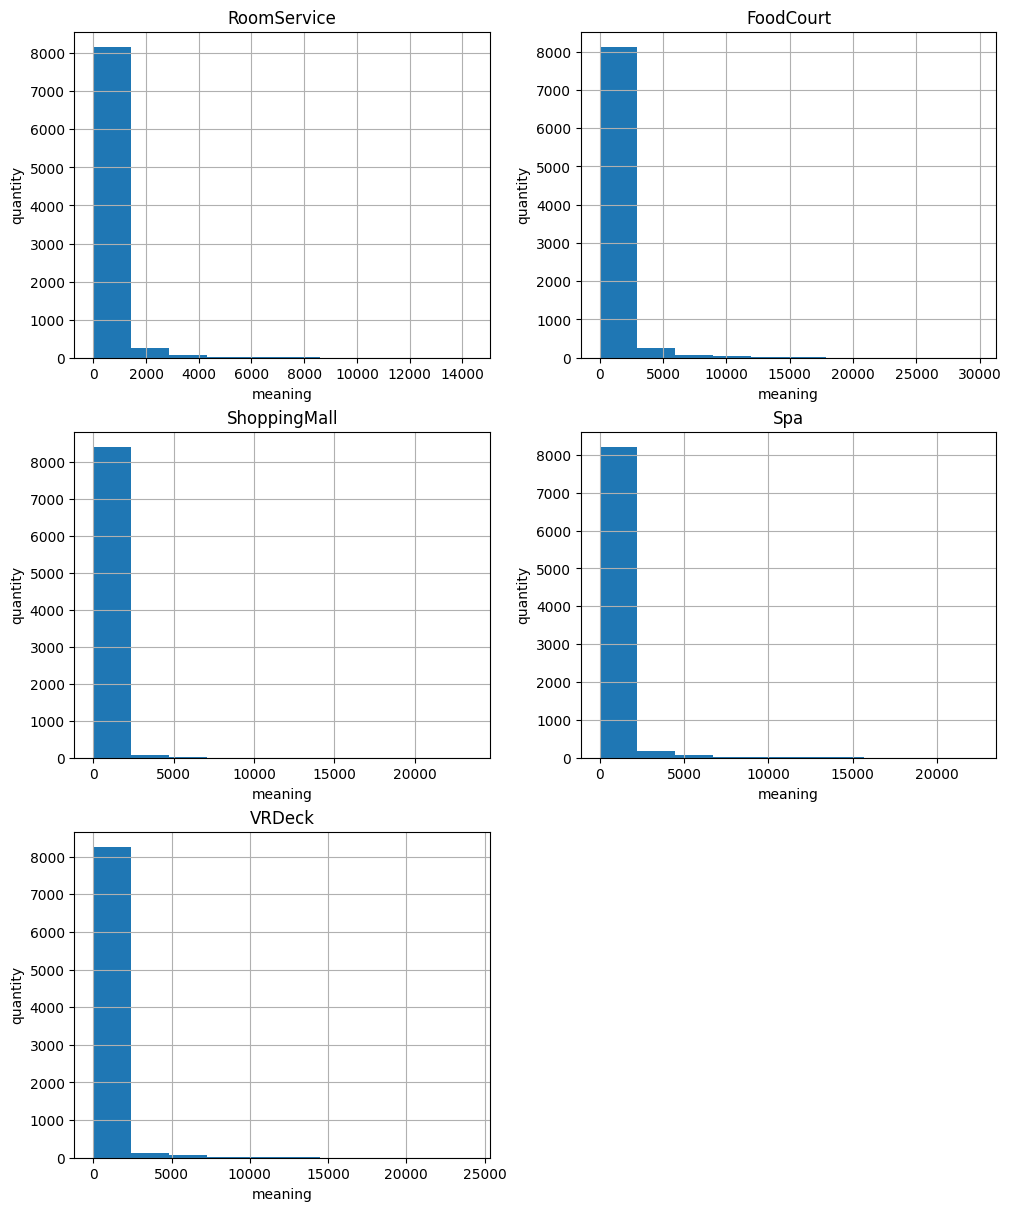

In [27]:
plt.figure(figsize=(10, 12), layout="constrained")
for i in range(len(services_columns)):
    plt.subplot(3, 2, i+1)
    column_draw(services_columns[i], train)

Видно, что во всех столбцах есть очень богатые пассажиры, потратившие очень существенные суммы) Посмотрим детальнее, как выглядит распределение в окрестности нуля:

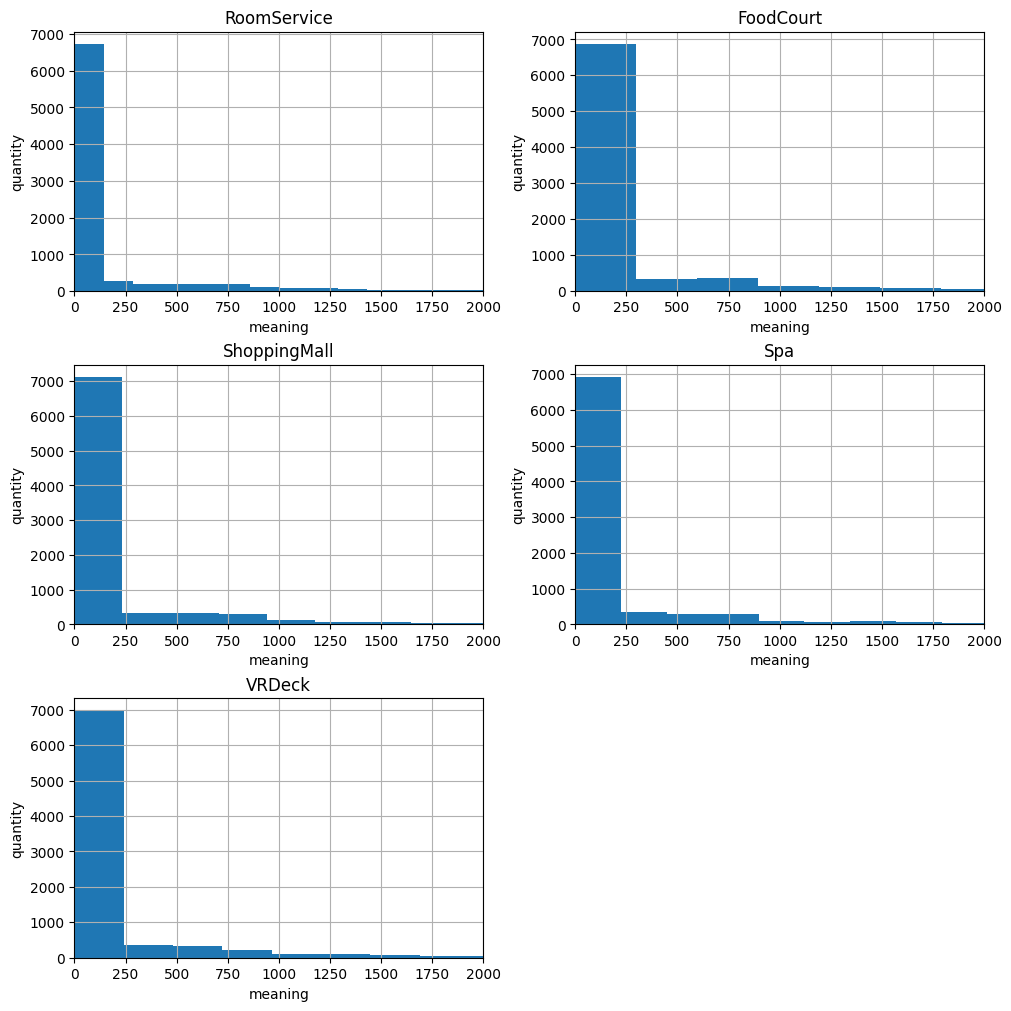

In [28]:
plt.figure(figsize=(10, 10), layout="constrained")
for i in range(len(services_columns)):
    plt.subplot(3, 2, i+1)
    column_draw_xlim(services_columns[i], train, 2000)

Видно, что большинство пассажиров не пользуются услугами допсервисов или расходы на них небольшие - значит, пропуски в этих столбцах можно заполнить нулевыми значениями.

In [29]:
train[services_columns] = train[services_columns].fillna(0)

## VIP-сервис

Начнём традиционно с того, чтобы посмотреть на распределение значений в столбце

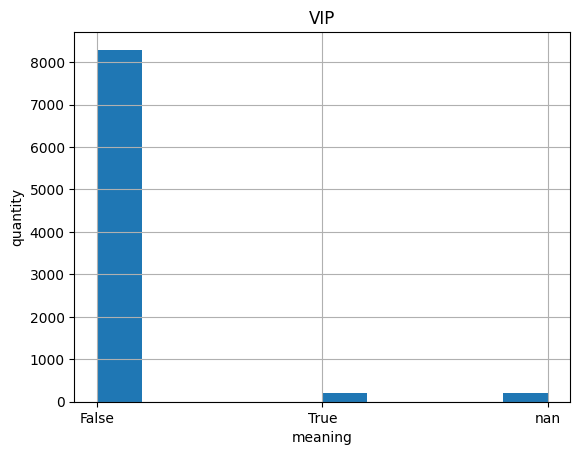

In [30]:
column_draw('VIP', train)

Подавляющее большинство пассажиров (около 95%) не пользуются ВИП-сервисом. Сделаем так: из распределения сумм, потраченных на допсервисы, помним о наличии людей, которые потратили внушительную сумму на такие услуги (выбросы в бОльшую сторону). Сделаем так:
- если клиент потратил внушительную сумму по крайней мере на один из сервисов - считаем его богатым вип-клиентом
- во всех остальных случаях считаем, что вип-сервис не подключен и заполняем пропуски False

In [31]:
def vip_fill(row):
  if sum([row[column] for column in services_columns]) > 20000:
    return True
  else:
    return False

In [32]:
train.loc[train['VIP'].isna(), 'VIP'] = train[train['VIP'].isna()].apply(vip_fill, axis=1)

## Имя пассажира

Столбец малоинформативен - можно было бы использовать его для восстановления пунктов отправления и назначения по одинаковости фамилий - но мы уже использовали для этого логику формирования ID пассажира. Значит, этот столбец можно безболезненно удалить.

In [33]:
train = train.drop(columns=['Name'])

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     8693 non-null   object 
 1   HomePlanet      8693 non-null   object 
 2   CryoSleep       8693 non-null   bool   
 3   Cabin           8494 non-null   object 
 4   Destination     8693 non-null   object 
 5   Age             8514 non-null   float64
 6   VIP             8693 non-null   object 
 7   RoomService     8693 non-null   float64
 8   FoodCourt       8693 non-null   float64
 9   ShoppingMall    8693 non-null   float64
 10  Spa             8693 non-null   float64
 11  VRDeck          8693 non-null   float64
 12  Transported     8693 non-null   bool   
 13  PassengerGroup  8693 non-null   object 
dtypes: bool(2), float64(6), object(6)
memory usage: 832.1+ KB


## Номер кабины

Знаем, что номер кабины сформирован следуюшим образом: номер имеет вид палуба/число/сторона, где P соответсвует левому борту, а S - правому

In [35]:
train['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

Разобьём номер кабины на компоненты, каждую запишем в отдельный столбец.

In [36]:
def side(row):
  try:
    return row['Cabin'].split('/')[-1]
  except:
    pass

In [37]:
def deck(row):
  try:
    return row['Cabin'].split('/')[0]
  except:
    pass

In [38]:
train['Side'] = train.apply(side, axis=1)

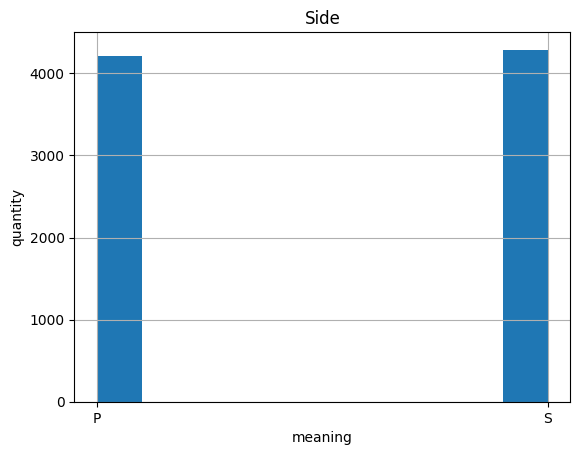

In [39]:
column_draw('Side', train)

Ожидаемо правого и левого борта примерно одинаковое количество - однако, в этом столбце есть пропуски, которые

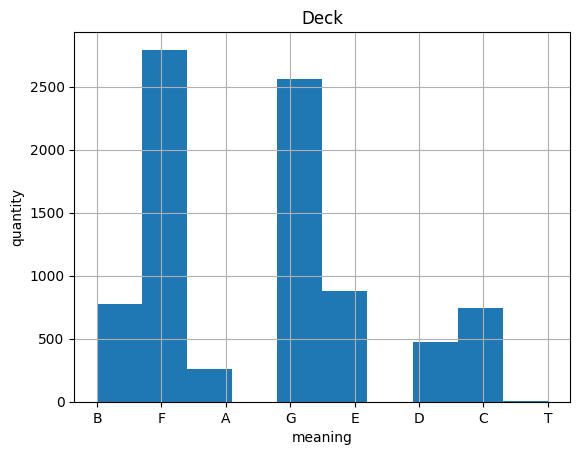

In [40]:
train['Deck'] = train.apply(deck, axis=1)
column_draw('Deck', train)

Популярностью пользуются F и G палубы - вероятнее всего, самые бюджетные. Исходя из того, что наименьшее количество пассажиров - на палубах A и B - можно предположить, что чем больше номер палубы - тем дороже номера. Проверим эту гипотезу в разделе исследовательского анализа данных.

<Axes: >

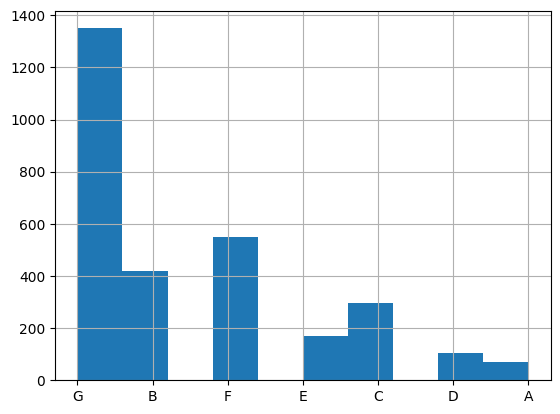

In [41]:
train[train['CryoSleep']==True]['Deck'].hist()

<Axes: >

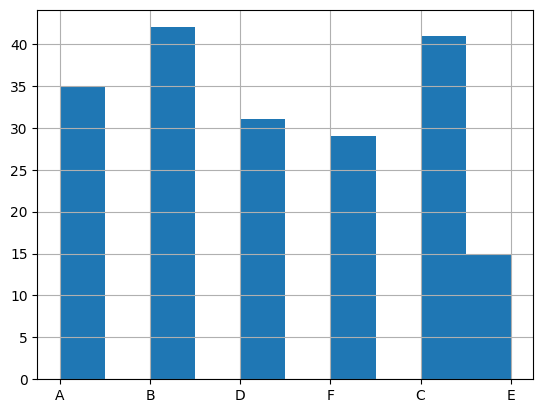

In [42]:
train[train['VIP']==True]['Deck'].hist()

Видим, что среди пассажиров с палубы G нет ни одного пользователя вип-сервиса, но среди них же популярен криосон.

In [43]:
len(train[train['Deck'].isna()])

199

Для заполнения пропусков сначала вновь воспользуемся наличием групп пассажиров: предполагаем, что группа путешествует совместно - а значит, велика вероятность, что внутри одной группы будет совпадать палуба и сторона

In [44]:
for col in ['Deck', 'Side']:
  for group in train['PassengerGroup'].unique():
    try:
      train.loc[(train['PassengerGroup']==group) & (train[col].isna()), col] = \
        train[train['PassengerGroup']==group][col].value_counts().index[0]
    except:
      pass

In [45]:
len(train[train['Deck'].isna()])

99

In [46]:
len(train[train['Side'].isna()])

99

Удалось сократить пропуски вдвое, остальные пропуски - это на самом деле около одного процента всего датасета, поэтому ошибка в логике заполнения пропусков не приведёт к существенному изменению качества обучения модели. Сделаем так:

- пропуски в стороне зальём значением S (правый борт, его в распределоении немного больше - возможно, на другом борту расположена столовая вместо части кают)
- пропуски в палубе - значением F - вторая по популярности палуба - однако, пассажиры на этой палубе пользуются криосном (на самой бюджетной G палубе - нет)

In [47]:
train['Side'] = train['Side'].fillna('S')
train['Deck'] = train['Deck'].fillna('F')

Теперь номер кабины не нужен, удаляем:

In [48]:
train = train.drop('Cabin', axis=1)

##  Возраст

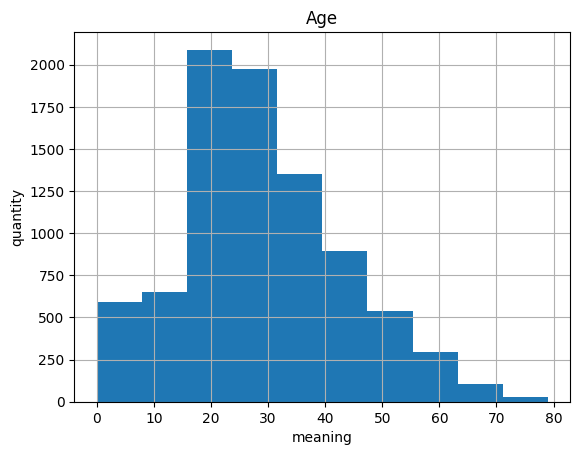

In [49]:
column_draw('Age', train)

Распределение возраста пассажиров носит вид распределения Гаусса с пиком в районе двадцати лет - значит, можно заполнить пропуски медианным значением.

In [50]:
train['Age'] = train['Age'].fillna(train['Age'].median())

## Целевой признак

Посмотрим на распределение целевого признака - был ли пассажир доставлен в другое измерение

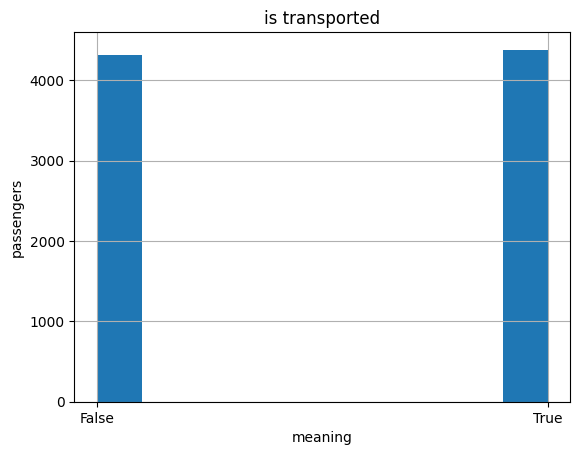

In [51]:
train['Transported'].astype('str').hist();
plt.title('is transported')
plt.xlabel('meaning')
plt.ylabel('passengers');

Приятная новость: количество значений в целевом признаке примерно одинаковое - а значит, у нас нет явного дисбаланса целевого признака.

## Вывод по разделу

Проведён предварительный обзор обучающего датасета. В нашем распоряжении 14 признаков, из них один - целевой. Все признаки кроме целевого и ID пассажира содержат пропуски. Признаки есть как количественные (потраченные на допуслуги средства, возраст) так и категориальные. Заполнены все пропуски. Добавлены новые признаки - группа пассажира (следствие алгоритма формирования ID пассажира), а также расположение каюты - палуба и сторона.

# Добавление новых признаков

Добавим новые признаки. После исследовательского анализа проведём анализ на мультиколлинеарность и на этой почве уже будем принимать решение о том, какие признаки использовать для построения модели.

## Сумма расходов за доп. сервис

## Путешествует ли в группе или один

# Исследовательский анализ данных

Начнём с того, чтобы посмотреть на значения признаков в разрезе значения целевого признака на обучающей выборке

In [52]:
#функция для отображения распределения признака в разрезе значения целевого признака
def column_target_draw(column):
    plt.hist([train[train['Transported']==True][column], train[train['Transported']==False][column]],
             label = ['transported', 'not transported'])
    plt.xlabel('meaning')
    plt.ylabel('quantity')
    plt.legend()
    plt.title(train[column].name);

In [53]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'PassengerGroup', 'Side', 'Deck'],
      dtype='object')

In [54]:
#список всех признаков - кроме целевого
columns_without_target = list(train.drop(['Transported', 'PassengerId', 'PassengerGroup'], axis=1).columns)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


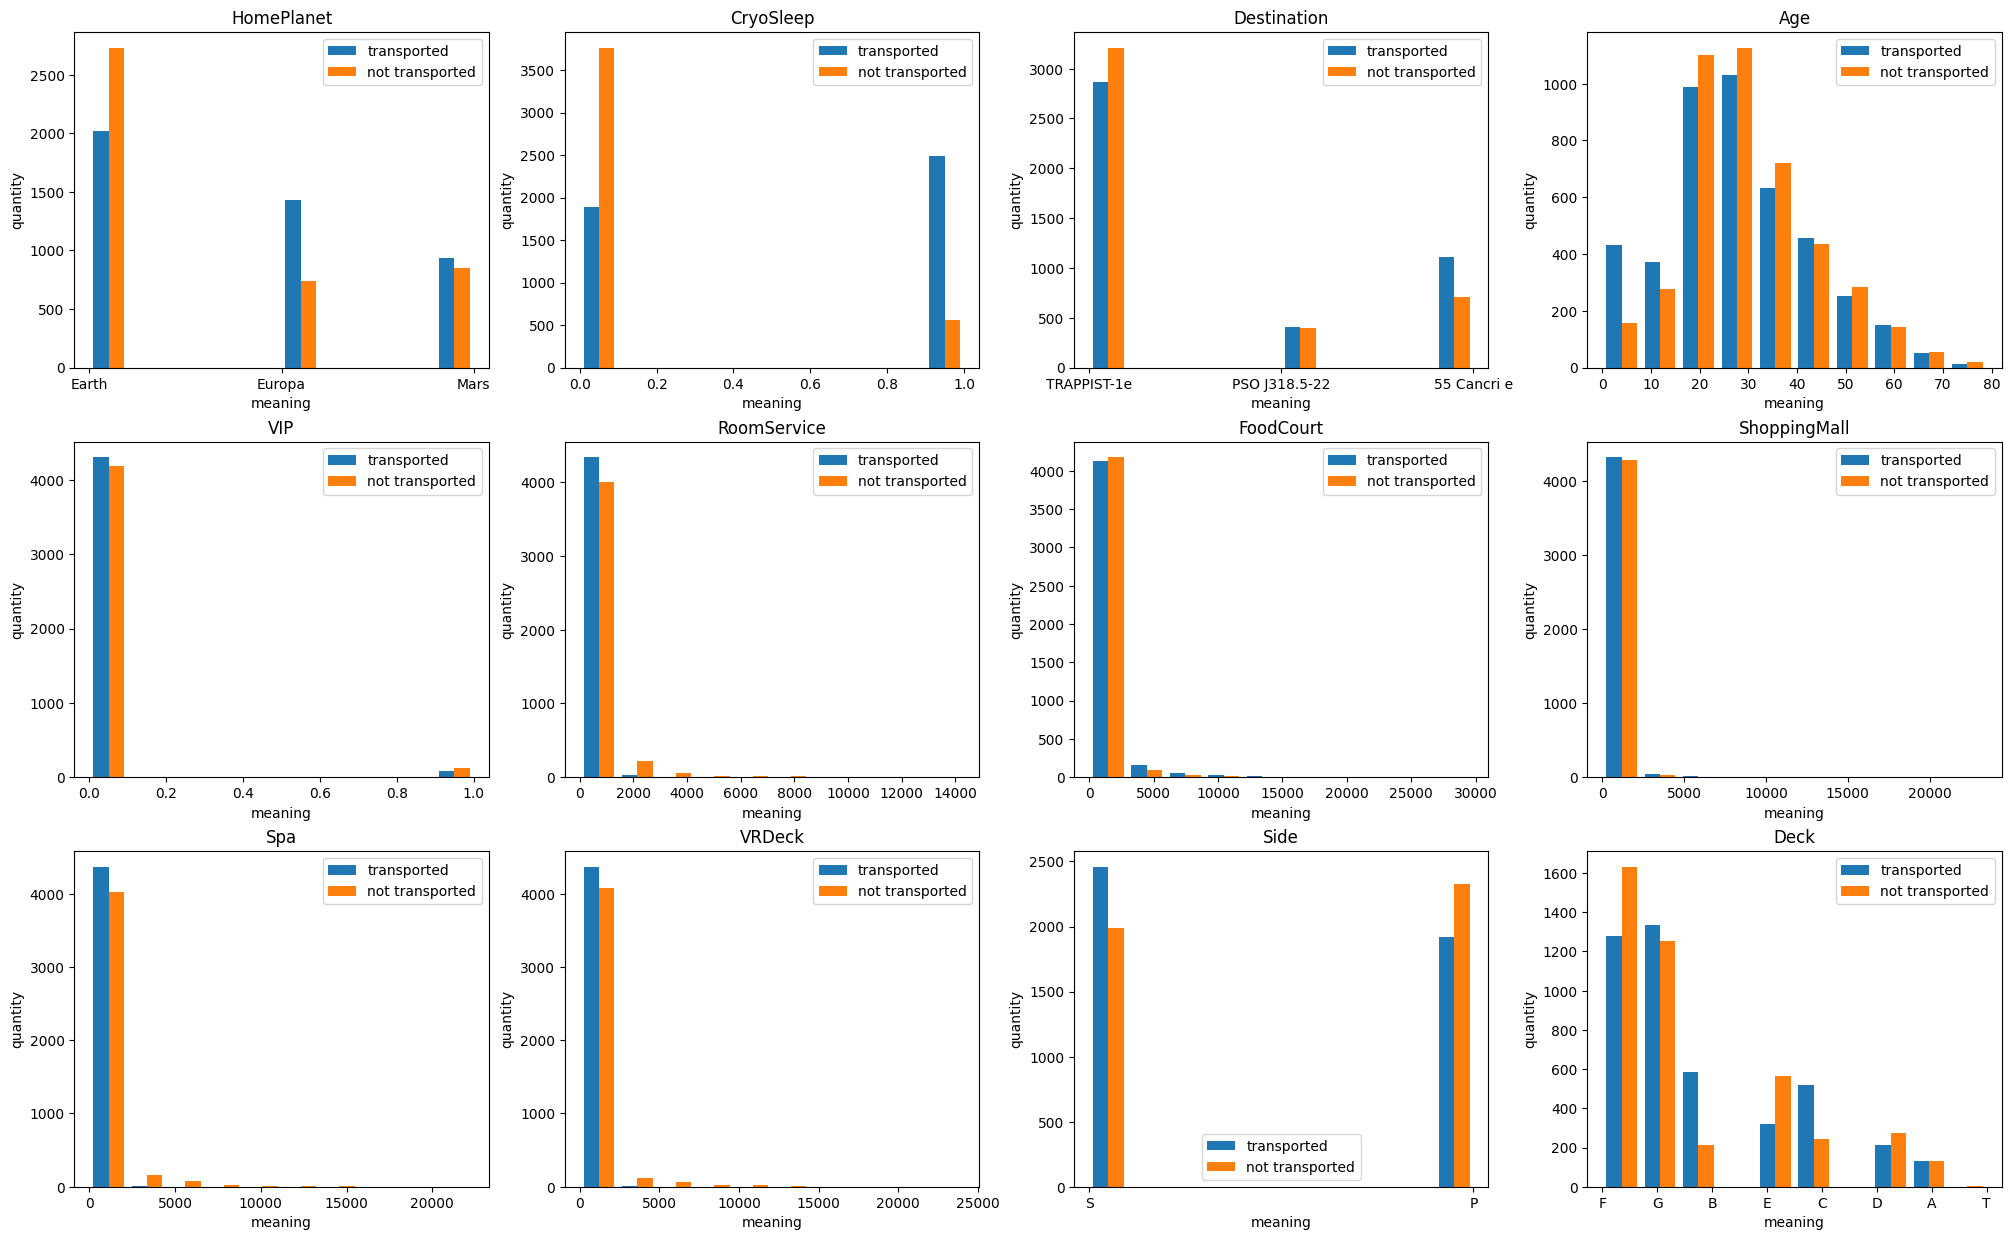

In [55]:
plt.figure(figsize=(20, 19), layout="constrained")
for i in range(len(columns_without_target)):
    plt.subplot(5, 4, i+1)
    column_target_draw(columns_without_target[i]);

- Видно явное влияние криосна на выживаемость: неспящие существенно реже долетали до другого измерения
- можно ожидать важность введённого признака стороны: на левом борту больше пассажиров не были доставлены в другое измерение, на правом - дисбаланс в другую сторону
- Среди тех, кто летел с Земли, больше не доставленных
- Пассажиры, потратившие внушительную сумму на спа и виртуальную реальность, в основном остались в текущем измерении
- на самой дешёвой палубе F перевес в сторону оставшихся в текущем измерении

По предварительному обзору данных наметили три категории клиентов: эконом, средний и премиум-сегмент. Их можно

# ваш код здесь
for typ in data['income_type'].unique():
    data.loc[(data['income_type']==typ) & (data['total_income'].isna()), 'total_income'] = data.loc[data['income_type']==typ, 'total_income'].median()

In [ ]:
train['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [ ]:
#функция для отображения распределения признака в разрезе значения целевого признака
def column_target_draw(column):
    plt.hist([data[data['not_active']==0][column], data[data['not_active']==1][column]], label = ['active clients', 'disactive clients'])
    plt.xlabel('meaning')
    plt.ylabel('quantity')
    plt.legend()
    plt.title(data[column].name)

доп признаки
- путешествует ли в группе или один
- общая потраченная сумма